# Analysis of fragmented malware detection by Suricata

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import glob

import re
from collections import defaultdict

import orjson

In [2]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [3]:
def get_json_data(file):
    return [orjson.loads(line) for line in open(file, "rb")]

In [4]:
def get_alerts_and_packets(json_data):
    alerts = [line for line in json_data if "alert" in line]
    packets = len(json_data)
    return alerts, packets

In [5]:
def get_signatures(alerts):
    nmbr_signatures = defaultdict(int)
    severity = defaultdict(int)
    packets = 0
    for entry in alerts:
        nmbr_signatures[entry['alert']['signature']] += 1
        severity[entry['alert']['signature']] = entry['alert']['severity']
    return nmbr_signatures, severity

In [6]:
def plot_alerts(nmbr_signatures):    
    x_ticks = [i for i in nmbr_signatures.keys()]
    xlabels_new = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in x_ticks]

    fig, ax = plt.subplots()
    
    ax.set_xticks(np.arange(len(nmbr_signatures)), xlabels_new)
    ax.set_ylabel('Number of alerts')
    ax.set_xlabel('Alert name')
    ax.set_title('Number of alerts in file')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.bar(np.arange(len(nmbr_signatures)), nmbr_signatures.values())

In [7]:
directory = os.fsencode('suricata_logs')

total_packets = []
total_nmbr_signatures = []
total_severity = []
for filepath in sorted(glob.glob('***/**/*.json')):
    json_data = get_json_data(filepath)
    alerts, packets = get_alerts_and_packets(json_data)
    nmbr_signatures, severity = get_signatures(alerts)

In [8]:
file = "suricata_logs/All.ElectroRAT/eve.json"
json_data = get_json_data(file)
alerts, packets = get_alerts_and_packets(json_data)
nmbr_signatures, severity = get_signatures(alerts)

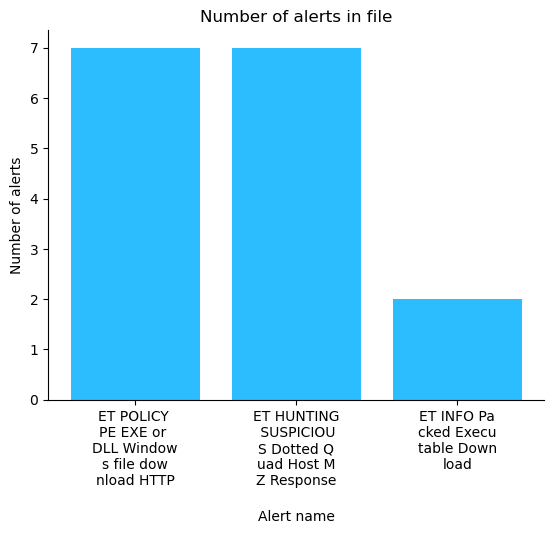

In [9]:
plot_alerts(nmbr_signatures)